In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
label_to_description = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress',
                        4: 'Coat', 5: 'Sandal', 6: 'Shirt',
                       7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot',
                        }

In [4]:
path_to_datasets = '/home/lor/Datasets/FashionMNIST/FashionMNIST/processed/training.pt'
samples = torch.load(path_to_datasets)
features = samples[0]
targets = samples[1]
print(features.shape, targets.shape)

torch.Size([60000, 28, 28]) torch.Size([60000])


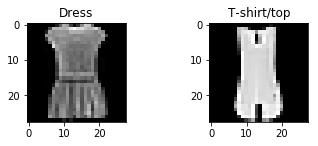

In [29]:
ax = plt.subplot(2, 2, 1)
plt.imshow(np.array(features[3]), cmap='gray')
ax.set_title(label_to_description[targets.storage()[3]])
ax = plt.subplot(2, 2, 2)
plt.imshow(np.array(features[4]), cmap='gray')
ax.set_title(label_to_description[targets.storage()[4]])
plt.show()
# plt.title(label_to_description[targets.storage()[3]])
# label_to_description[targets.storage()[3]]

In [10]:
from torch.utils.data import Dataset, DataLoader

In [11]:
class UserDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        return (self.targets[idx], self.features[idx])

In [12]:
train_dataset = UserDataset(features, targets)
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=4)

In [15]:
one_iter = next(iter(train_dataloader))

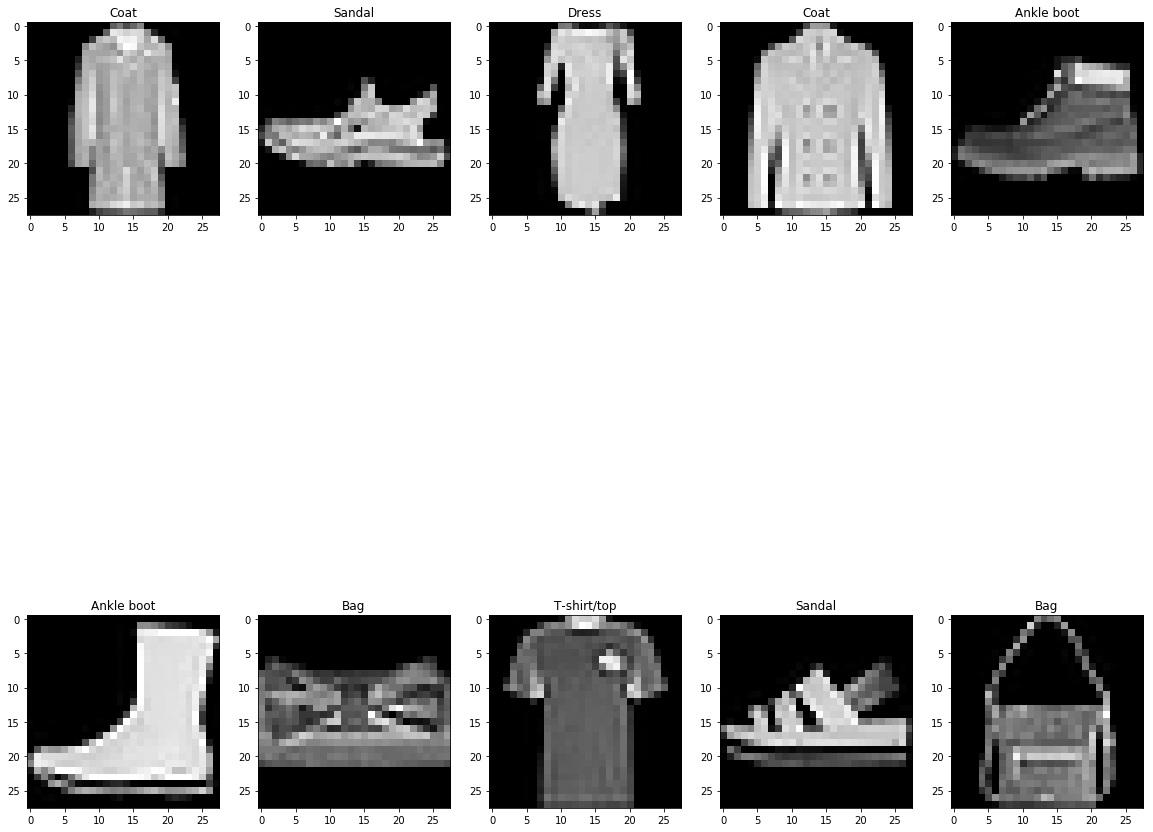

In [44]:
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(one_iter[1][i], cmap='gray')
    ax.set_title(label_to_description[one_iter[0].storage()[i]])